In [37]:
import os
import shutil
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import cv2
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import label_binarize
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ROCAUC
import lime
import lime.lime_tabular
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from tqdm import tqdm
import time
import shap
from lime import lime_image
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

from joblib import dump, load


In [2]:
# Define paths
source_dir = 'D:\\Beetle photos\\fingerprints'
train_dir = 'D:\\Beetle photos\\train'
test_dir = 'D:\\Beetle photos\\test'
augmented_dir = 'D:\\Beetle photos\\augmented'

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(augmented_dir, exist_ok=True)

In [3]:
image_paths = []
classes = []

In [4]:
for root, dirs, files in os.walk(source_dir):
    for file in files:
        if file.endswith('_img.jpg'):  # Only consider _img.jpg files
            image_path = os.path.join(root, file)
            image_paths.append(image_path)
            class_label = file.split('_')[1]  # Extract class (individual beetle ID)
            classes.append(class_label)

# Count occurrences of each class
class_counts = Counter(classes)

In [5]:
class_counts

Counter({'5F01': 67,
         '9F01': 64,
         '2F01': 61,
         'C12F01': 60,
         '9M01': 60,
         'C12F02': 58,
         '9M02': 57,
         'C12M01': 57,
         '10M02': 56,
         'C4M01': 54,
         '3F01': 51,
         '10M01': 50,
         '2M01': 49,
         '9F02': 49,
         'C15F01': 48,
         'C4F01': 47,
         '1M01': 47,
         '11M01': 47,
         '5M01': 45,
         '9F03': 45,
         'C2F01': 44,
         'C11F01': 43,
         'C12M02': 43,
         '2F02': 42,
         '10F01': 42,
         '5F02': 42,
         'C12F03': 42,
         '9M03': 41,
         '3M01': 40,
         '14M01': 40,
         '4F01': 39,
         '9F05': 39,
         'C2AM-24': 38,
         '8M01': 38,
         '10F02': 38,
         '11F01': 38,
         '14F01': 38,
         'C12F04': 38,
         '8F01': 38,
         '5M02': 38,
         'C1F01': 37,
         'C4F02': 37,
         'C16F01': 37,
         'K16D-11': 36,
         '3F02': 36,
         'C16M01':

In [6]:
# Print first 10 image paths and their corresponding labels to verify
for i in range(10):
    print(f"Image Path: {image_paths[i]}, Label: {classes[i]}")


Image Path: D:\Beetle photos\fingerprints\05-29_L4AA-16_04\05-29_L4AA-16_04_img.jpg, Label: L4AA-16
Image Path: D:\Beetle photos\fingerprints\05-23_C14F01_04\05-23_C14F01_04_img.jpg, Label: C14F01
Image Path: D:\Beetle photos\fingerprints\08-19_X2K-08_02\08-19_X2K-08_02_img.jpg, Label: X2K-08
Image Path: D:\Beetle photos\fingerprints\06-29_C2AL-22_01\06-29_C2AL-22_01_img.jpg, Label: C2AL-22
Image Path: D:\Beetle photos\fingerprints\08-04_L6C-13_05\08-04_L6C-13_05_img.jpg, Label: L6C-13
Image Path: D:\Beetle photos\fingerprints\07-23_L6B-13_01\07-23_L6B-13_01_img.jpg, Label: L6B-13
Image Path: D:\Beetle photos\fingerprints\07-11_C1F01_06\07-11_C1F01_06_img.jpg, Label: C1F01
Image Path: D:\Beetle photos\fingerprints\09-12_C5F01_06\09-12_C5F01_06_img.jpg, Label: C5F01
Image Path: D:\Beetle photos\fingerprints\09-01_L4V-20_02\09-01_L4V-20_02_img.jpg, Label: L4V-20
Image Path: D:\Beetle photos\fingerprints\05-26_L4X-13_03\05-26_L4X-13_03_img.jpg, Label: L4X-13


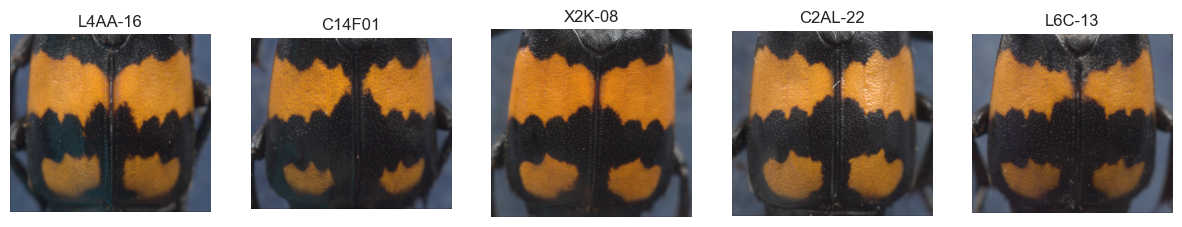

In [7]:
def display_images(image_paths, labels, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        img = cv2.imread(image_paths[i])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_rgb)
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

# Display the first 5 images with their labels
display_images(image_paths, classes, num_images=5)


In [8]:
# Check for missing labels and comma-separated labels
missing_labels = [path for path in image_paths if not path.split('_')[1]]
comma_separated_labels = [label for label in classes if ',' in label]

if missing_labels:
    print("Images with missing labels found:", missing_labels)
else:
    print("No images with missing labels found.")

if comma_separated_labels:
    print("Labels with commas found:", comma_separated_labels)
else:
    print("No labels with commas found.")


Images with missing labels found: ['D:\\Beetle photos\\fingerprints\\07-27__03\\07-27__03_img.jpg', 'D:\\Beetle photos\\fingerprints\\10-26__01\\10-26__01_img.jpg', 'D:\\Beetle photos\\fingerprints\\08-22__01\\08-22__01_img.jpg', 'D:\\Beetle photos\\fingerprints\\07-06__05\\07-06__05_img.jpg', 'D:\\Beetle photos\\fingerprints\\06-08__03\\06-08__03_img.jpg', 'D:\\Beetle photos\\fingerprints\\07-27__05\\07-27__05_img.jpg', 'D:\\Beetle photos\\fingerprints\\07-06__07\\07-06__07_img.jpg', 'D:\\Beetle photos\\fingerprints\\07-27__04\\07-27__04_img.jpg', 'D:\\Beetle photos\\fingerprints\\07-20__01\\07-20__01_img.jpg', 'D:\\Beetle photos\\fingerprints\\08-22__02\\08-22__02_img.jpg', 'D:\\Beetle photos\\fingerprints\\07-20__03\\07-20__03_img.jpg', 'D:\\Beetle photos\\fingerprints\\07-06__06\\07-06__06_img.jpg', 'D:\\Beetle photos\\fingerprints\\07-27__02\\07-27__02_img.jpg', 'D:\\Beetle photos\\fingerprints\\07-20__04\\07-20__04_img.jpg']
Labels with commas found: ['4M01, 8F01', 'C2F01, C3M03'

In [9]:
# Identify examples with missing or malformed labels
invalid_indices = [i for i, label in enumerate(classes) if not label or ',' in label]

# Remove these examples from the dataset
image_paths = [image_paths[i] for i in range(len(image_paths)) if i not in invalid_indices]
classes = [classes[i] for i in range(len(classes)) if i not in invalid_indices]

# Verify the changes
print(f"Number of images after removal: {len(image_paths)}")
print(f"Number of classes after removal: {len(classes)}")

# Count occurrences of each class again to verify
class_counts = Counter(classes)
print("Updated class counts:", class_counts)

Number of images after removal: 11751
Number of classes after removal: 11751
Updated class counts: Counter({'5F01': 67, '9F01': 64, '2F01': 61, 'C12F01': 60, '9M01': 60, 'C12F02': 58, '9M02': 57, 'C12M01': 57, '10M02': 56, 'C4M01': 54, '3F01': 51, '10M01': 50, '2M01': 49, '9F02': 49, 'C15F01': 48, 'C4F01': 47, '1M01': 47, '11M01': 47, '5M01': 45, '9F03': 45, 'C2F01': 44, 'C11F01': 43, 'C12M02': 43, '2F02': 42, '10F01': 42, '5F02': 42, 'C12F03': 42, '9M03': 41, '3M01': 40, '14M01': 40, '4F01': 39, '9F05': 39, 'C2AM-24': 38, '8M01': 38, '10F02': 38, '11F01': 38, '14F01': 38, 'C12F04': 38, '8F01': 38, '5M02': 38, 'C1F01': 37, 'C4F02': 37, 'C16F01': 37, 'K16D-11': 36, '3F02': 36, 'C16M01': 36, 'K16B-21': 36, '9F04': 35, 'C3M01': 35, 'K16A-12': 34, 'L4X-14': 34, 'C15F02': 34, 'C16F02': 34, 'K16B-20': 34, 'C12F05': 34, '10F03': 33, '2M03': 33, '2M02': 33, '5F03': 32, '10M03': 32, '2M04': 32, 'C13F01': 32, 'C1M01': 32, 'L5B-14': 32, '11F02': 31, 'C16F04': 31, '1F01': 31, 'C3F01': 30, '9M04': 

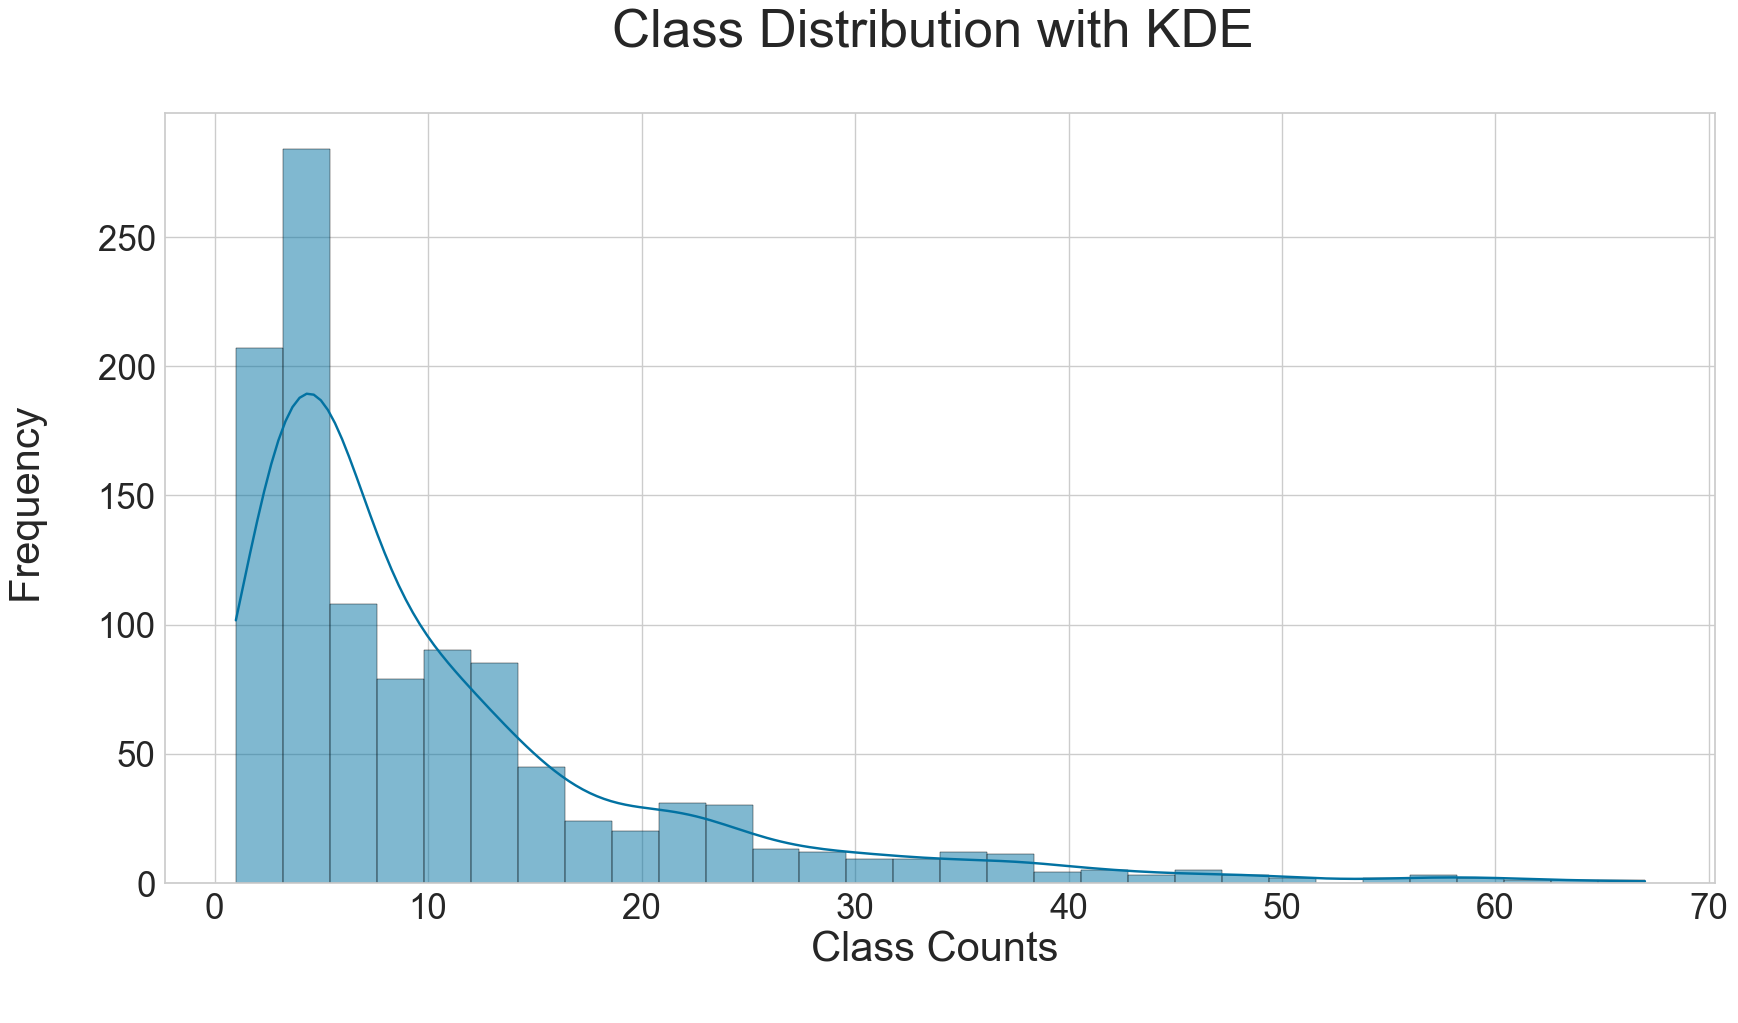

Number of unique classes: 1101


In [10]:
# Convert counts to a list of counts
count_values = list(class_counts.values())

# Plot the histogram
plt.figure(figsize=(20, 10))
sns.histplot(count_values, kde=True, bins=30)
plt.xlabel('Class Counts \n', fontsize=30)
plt.ylabel('Frequency \n', fontsize=30)
plt.title('Class Distribution with KDE \n', fontsize=38)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

# Show the plot
plt.show()

# Print the number of unique classes
print("Number of unique classes:", len(class_counts))

In [11]:
mean_samples = np.mean(list(class_counts.values()))
median_samples = np.median(list(class_counts.values()))

print(f"Mean number of samples per class: {mean_samples}")
print(f"Median number of samples per class: {median_samples}")


Mean number of samples per class: 10.673024523160763
Median number of samples per class: 7.0


In [12]:
min_samples = np.median(list(class_counts.values()))
few_sample_classes = [cls for cls, count in class_counts.items() if count < min_samples]

print(f"Classes with fewer than {min_samples} samples: {few_sample_classes}")
print(f"Number of such classes: {len(few_sample_classes)}")

Classes with fewer than 7.0 samples: ['L6B-13', 'L4X-13', 'X2D-03', 'X2M-01', 'L6AH-14', 'X2A-03', 'L5J-07', 'X2A-24', 'L5J-04', 'L6W-17', 'L1AE-08', 'C2F06', 'K16K-15', 'C5M13', 'G1AI-16', 'L6AF-18', 'C12M06', 'C3F13', 'L5K-13', 'L5C-12', 'L4W-10', 'C2AL-24', 'L5AF-04', 'K16O-13', 'C7M02', 'K16K-14', 'K16I-24', 'K16I-15', 'C9D-02', '6M02', 'K16C-13', 'K17K-03', 'X2H-04', 'L4X-16', 'C11F04', 'K16A-14', 'K16N-21', 'C14M02', 'C5F04', 'L5T-15', 'L5G-10', 'G11J-05', 'C6F01', 'C8M03', 'L6E-12', 'X2D-01', 'C15M06', '11F05', 'C11M04', 'C5M12', 'C5M06', '7F07', 'L1AC-15', 'C8F05', 'C8F04', '15M04', 'L5H-15', 'L5G-14', 'C6H-18', 'C6H-17', 'C6H-06', '9M17', '9M16', '9M14', '10M09', 'L4V-12', 'L4V-08', 'L4V-05', 'K15M-08', '4F05', '8M05', '3M08', 'L6AB-18', 'G2AF-02', 'L5AK-21', 'G11L-01', 'L5AB-10', 'C9B-14', 'X2L-04', 'C2AM-15', 'C5F05', 'G1AI-10', 'L5J-13', 'L6T-05', 'G1AI-12', 'C2AM-14', 'L4X-17', 'C9F05', 'L5J-08', 'C9D-06', 'K16C-11', 'C2AM-12', 'X2A-23', 'C12U01', 'G1AI-13', 'X2M-03', 'K16

In [13]:
def augment_image(image_path, augment_count):
    img = cv2.imread(image_path)
    augmented_images = []
    for i in range(augment_count):
        # Rotate image by a random angle
        angle = random.choice([cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_COUNTERCLOCKWISE])
        rotated_img = cv2.rotate(img, angle)
        augmented_images.append(rotated_img)
    return augmented_images
# Augment images for underrepresented classes
augmented_image_paths = []
augmented_classes = []
for image_path, class_label in zip(image_paths, classes):
    if class_label in few_sample_classes:
        existing_count = class_counts[class_label]
        augment_count = int(min_samples - existing_count)
        augmented_images = augment_image(image_path, augment_count)
        for i, augmented_img in enumerate(augmented_images):
            augmented_image_path = os.path.join(augmented_dir, f"{os.path.basename(image_path).split('.')[0]}_aug{i}.jpg")
            cv2.imwrite(augmented_image_path, augmented_img)
            augmented_image_paths.append(augmented_image_path)
            augmented_classes.append(class_label)

In [14]:
# Combine original and augmented datasets
combined_image_paths = image_paths + augmented_image_paths
combined_classes = classes + augmented_classes

In [15]:

# Perform initial train-test split
train_paths, test_paths, train_classes, test_classes = train_test_split(
    combined_image_paths, combined_classes, test_size=0.2, stratify=combined_classes, random_state=42
)

funciton and call to copy augmented images do not run

In [16]:
# Copy files to train and test directories
def copy_files(file_paths, dest_dir):
    for file_path in file_paths:
        file_name = os.path.basename(file_path)
        dest_path = os.path.join(dest_dir, file_name)
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        shutil.copy(file_path, dest_path)

copy_files(train_paths, train_dir)
copy_files(test_paths, test_dir)

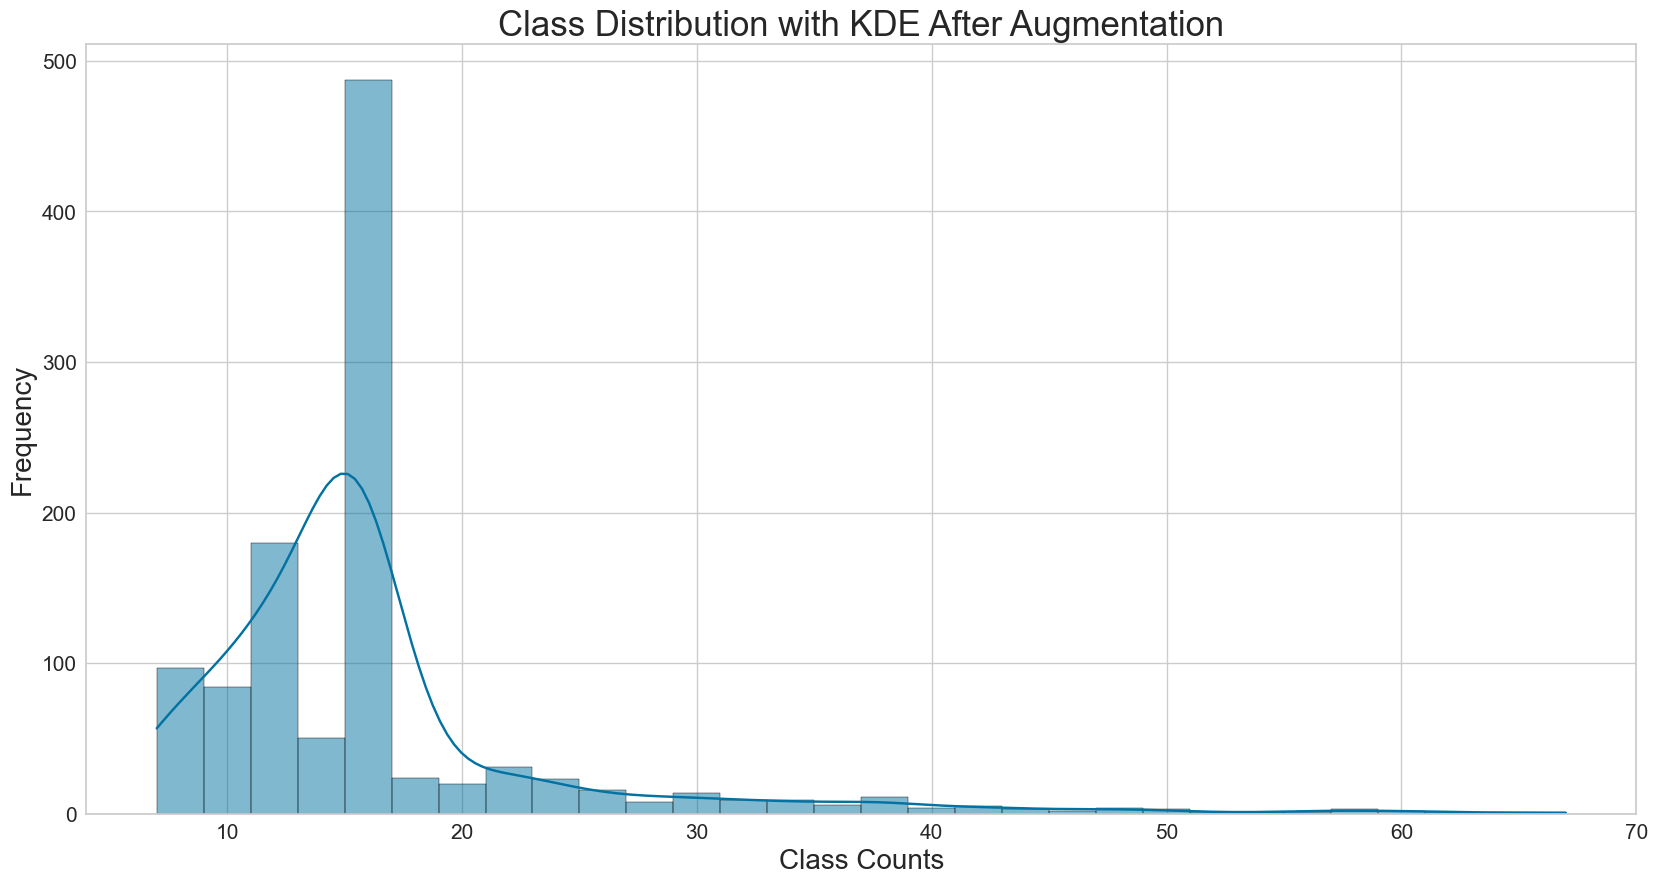

Number of unique classes after augmentation: 1101


In [17]:
# Visualize the class distribution after augmentation
class_counts_after = Counter(combined_classes)

plt.figure(figsize=(20, 10))
sns.histplot(list(class_counts_after.values()), kde=True, bins=30)
plt.xlabel('Class Counts')
plt.ylabel('Frequency')
plt.title('Class Distribution with KDE After Augmentation')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Class Counts', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.title('Class Distribution with KDE After Augmentation', fontsize=25)
plt.show()

# Print the number of unique classes
print("Number of unique classes after augmentation:", len(class_counts_after))

In [18]:
print("Class counts before augmentation:", class_counts, "\n",len(class_counts))
print("Class counts after augmentation:",class_counts_after, "\n",len(class_counts_after))


Class counts before augmentation: Counter({'5F01': 67, '9F01': 64, '2F01': 61, 'C12F01': 60, '9M01': 60, 'C12F02': 58, '9M02': 57, 'C12M01': 57, '10M02': 56, 'C4M01': 54, '3F01': 51, '10M01': 50, '2M01': 49, '9F02': 49, 'C15F01': 48, 'C4F01': 47, '1M01': 47, '11M01': 47, '5M01': 45, '9F03': 45, 'C2F01': 44, 'C11F01': 43, 'C12M02': 43, '2F02': 42, '10F01': 42, '5F02': 42, 'C12F03': 42, '9M03': 41, '3M01': 40, '14M01': 40, '4F01': 39, '9F05': 39, 'C2AM-24': 38, '8M01': 38, '10F02': 38, '11F01': 38, '14F01': 38, 'C12F04': 38, '8F01': 38, '5M02': 38, 'C1F01': 37, 'C4F02': 37, 'C16F01': 37, 'K16D-11': 36, '3F02': 36, 'C16M01': 36, 'K16B-21': 36, '9F04': 35, 'C3M01': 35, 'K16A-12': 34, 'L4X-14': 34, 'C15F02': 34, 'C16F02': 34, 'K16B-20': 34, 'C12F05': 34, '10F03': 33, '2M03': 33, '2M02': 33, '5F03': 32, '10M03': 32, '2M04': 32, 'C13F01': 32, 'C1M01': 32, 'L5B-14': 32, '11F02': 31, 'C16F04': 31, '1F01': 31, 'C3F01': 30, '9M04': 30, 'C9M01': 30, 'L4AA-14': 30, 'G1AI-03': 30, 'L5B-13': 30, 'L4V

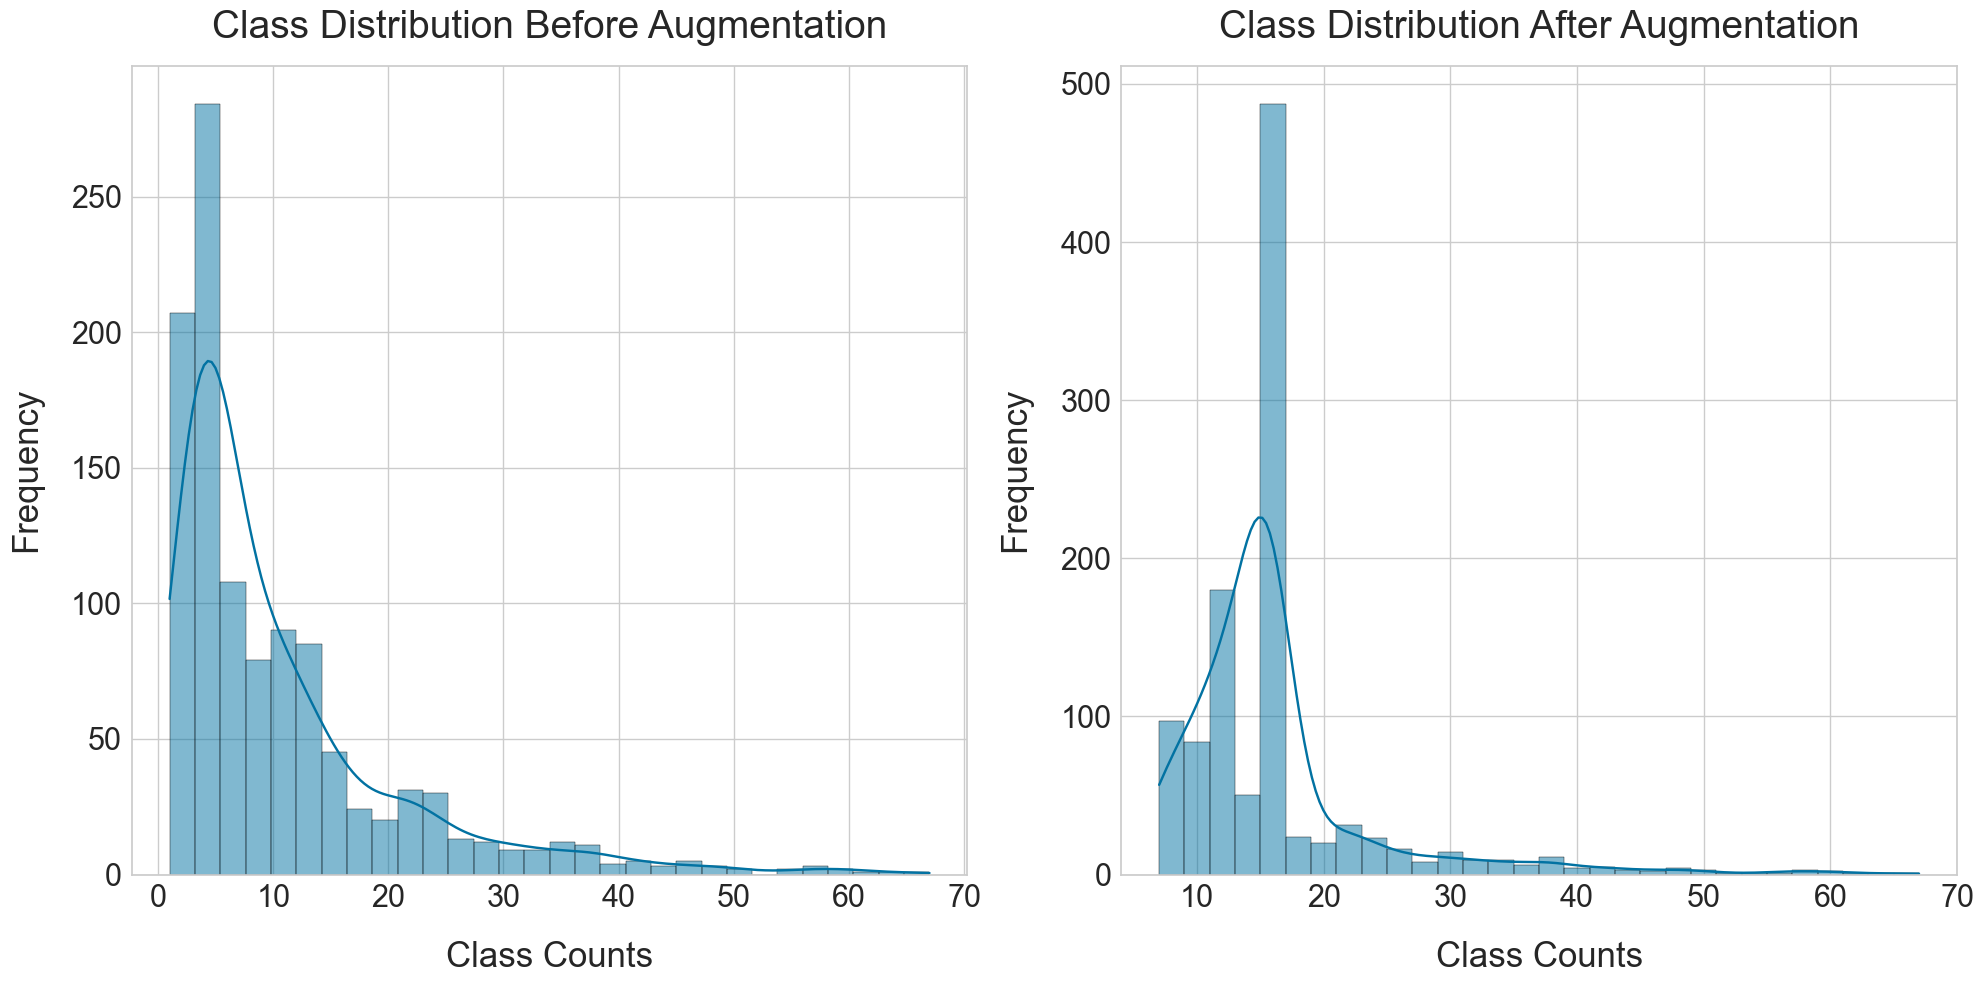

In [19]:
# Plot the class distribution before and after augmentation
plt.figure(figsize=(20, 10))

# Before augmentation
plt.subplot(1, 2, 1)
sns.histplot(list(class_counts.values()), kde=True, bins=30)
plt.xlabel('Class Counts', fontsize=25, labelpad=20)
plt.ylabel('Frequency', fontsize=25, labelpad=20)
plt.title('Class Distribution Before Augmentation', fontsize=28, pad=20)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

# After augmentation
plt.subplot(1, 2, 2)
sns.histplot(list(class_counts_after.values()), kde=True, bins=30)
plt.xlabel('Class Counts', fontsize=25, labelpad=20)
plt.ylabel('Frequency', fontsize=25, labelpad=20)
plt.title('Class Distribution After Augmentation', fontsize=28, pad=20)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.tight_layout()
plt.show()

SIFT extraction

In [20]:
# Function to extract and group SIFT descriptors by class with default opencv parameters passed 
def extract_sift_descriptors_by_class(image_paths, class_labels, nfeatures=0, nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6):
    sift = cv2.SIFT_create(nfeatures=nfeatures, nOctaveLayers=nOctaveLayers, 
                           contrastThreshold=contrastThreshold, edgeThreshold=edgeThreshold, sigma=sigma)
    descriptors_by_class = {cls: [] for cls in set(class_labels)}
    for image_path, class_label in zip(image_paths, class_labels):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            keypoints, descriptors = sift.detectAndCompute(img, None)
            if descriptors is not None:
                descriptors_by_class[class_label].extend(descriptors)
    return descriptors_by_class

# Function to perform stratified sampling of descriptors
def stratified_sampling_descriptors(descriptors_by_class, max_descriptors):
    all_descriptors = []
    total_descriptors = sum(len(descriptors) for descriptors in descriptors_by_class.values())
    sampling_ratio = max_descriptors / total_descriptors
    
    for class_label, descriptors in descriptors_by_class.items():
        num_samples = min(len(descriptors), int(len(descriptors) * sampling_ratio))
        sampled_descriptors = random.sample(descriptors, num_samples)
        all_descriptors.extend(sampled_descriptors)
    
    return np.array(all_descriptors)

In [21]:
# Extract and group SIFT descriptors by class from training images
descriptors_by_class = extract_sift_descriptors_by_class(train_paths, train_classes, nfeatures=700,nOctaveLayers=5,  contrastThreshold=0.06)

In [22]:
max_descriptors = 10000  # Adjust this value based on your memory and computation limits
sampled_descriptors = stratified_sampling_descriptors(descriptors_by_class, max_descriptors)


In [23]:
# Function to count descriptors per class
# Function to count descriptors per class
def count_descriptors_per_class(sampled_descriptors, descriptors_by_class):
    class_counts = {cls: 0 for cls in descriptors_by_class.keys()}
    descriptor_set = set(map(tuple, sampled_descriptors))
    
    for class_label, descriptors in descriptors_by_class.items():
        class_counts[class_label] = len([desc for desc in descriptors if tuple(desc) in descriptor_set])
    
    return class_counts

class_counts = count_descriptors_per_class(sampled_descriptors, descriptors_by_class)
print("Class counts after sampling:", class_counts)
print("Number of unique classes:", len(class_counts))

Class counts after sampling: {'L5J-07': 15, 'X2K-06': 11, '7F04': 13, 'C7M01': 7, 'K16D-12': 7, 'C16F08': 8, '10F04': 11, 'L6Z-05': 17, '11F04': 6, 'C3M03': 10, 'C2AL-18': 6, 'L6R-07': 11, 'K17B-09': 15, '13F05': 2, 'K17C-12': 2, 'L5X-11': 9, 'L1AE-04': 9, 'L5AK-17': 7, 'L4X-17': 7, 'X2M-08': 5, 'K17I-08': 18, '9M17': 9, '7M03': 1, 'L5C-10': 10, '7F03': 14, 'L6V-15': 3, 'C1CC-08': 4, 'X2G-08': 9, 'C6H-16': 18, 'C9C-01': 9, 'L6R-10': 7, 'X2N-01': 5, 'C5M10': 14, 'L4V-03': 14, 'X2C-03': 7, 'C3F03': 3, '10F09': 4, '9M03': 16, 'C9B-11': 13, 'C11F06': 5, 'L6AG-14': 18, 'L6W-18': 20, 'C15M06': 7, 'K17K-03': 13, 'L4X-14': 28, 'C1CC-09': 4, 'C3F01': 10, 'L6AG-01': 6, 'C13F04': 5, 'L4Z-15': 19, 'L6Q-09': 12, '5M06': 3, '11M09': 13, '11M04': 7, 'C4M06': 2, 'X2D-02': 3, 'X2G-01': 16, 'L4V-02': 7, 'C16M05': 2, 'C3F09': 3, 'C9D-02': 16, '2M03': 16, 'C6H-09': 12, '13F02': 13, 'L5AF-18': 12, 'G2AG-03': 18, 'K16O-11': 12, 'X2D-07': 6, '2M07': 6, 'K15M-15': 16, 'C3F12': 12, 'C9D-01': 4, 'K16I-23': 16, 

Rebalancing

In [36]:
from imblearn.over_sampling import SMOTE

# Prepare data for SMOTE with a subset to avoid memory issues
sample_size = 70 # Adjust this value as needed to fit in memory
all_descriptors = []
all_labels = []
for label, descriptors in descriptors_by_class.items():
    sampled_descriptors = random.sample(descriptors, min(sample_size, len(descriptors)))
    all_descriptors.extend(sampled_descriptors)
    all_labels.extend([label] * len(sampled_descriptors))

# Convert lists to numpy arrays
all_descriptors = np.array(all_descriptors)
all_labels = np.array(all_labels)

# Apply SMOTE to balance the descriptors
smote = SMOTE(random_state=42)
descriptors_resampled, labels_resampled = smote.fit_resample(all_descriptors, all_labels)

# Check class counts after SMOTE
rebalanced_class_counts = Counter(labels_resampled)
print("Rebalanced Class Counts:")
print(rebalanced_class_counts)


Rebalanced Class Counts:
Counter({'': 70, 'C2AM-14': 70, 'L4V-10': 70, 'C15F08': 70, 'X2C-01': 70, 'K16I-15': 70, '2F02': 70, 'C15M02': 70, 'L6AF-21': 70, 'L6AA-09': 70, '8F05': 70, 'L16O-20': 70, 'X2D-11': 70, 'X2M-08': 70, 'G1AI-10': 70, 'C12F03': 70, 'X2D-02': 70, 'L4V-04': 70, 'X2K-04': 70, 'L5B-13': 70, 'L1AE-04': 70, 'L5X-11': 70, 'C16F03': 70, 'C13F01': 70, 'C5M09': 70, 'C5F07': 70, 'C16M04': 70, 'C3F07': 70, '9M04': 70, 'X2A-21': 70, 'K16B-10': 70, 'C12M01': 70, 'L6AH-03': 70, 'K16N-19': 70, 'C12M06': 70, '2F06': 70, 'C3F04': 70, 'L5AF-15': 70, 'L5U-17': 70, 'G1AI-11': 70, '13F01': 70, 'L6V-13': 70, 'L1AF-17': 70, 'C5L-10': 70, 'X2G-04': 70, 'K16I-19': 70, 'C6H-15': 70, 'X2C-02': 70, 'C16F09': 70, 'C5M12': 70, '9M03': 70, 'C2AM-18': 70, 'C5M05': 70, '4M01, 8F01': 70, 'L5N-16': 70, 'C2AM-05': 70, 'C9M04': 70, 'L6AA-07': 70, '9F07': 70, 'G2AF-06': 70, 'L6AI-07': 70, 'C12U01': 70, '9F13': 70, 'K16B-16': 70, 'X2L-03': 70, 'L4V-06': 70, 'L5K-13': 70, 'C12M04': 70, 'L4AA-28': 70, 'C4

In [37]:
# Check class counts after SMOTE
rebalanced_class_counts = Counter(labels_resampled)
print("Rebalanced Class Counts:")
print(rebalanced_class_counts)


Rebalanced Class Counts:
Counter({'': 70, 'C2AM-14': 70, 'L4V-10': 70, 'C15F08': 70, 'X2C-01': 70, 'K16I-15': 70, '2F02': 70, 'C15M02': 70, 'L6AF-21': 70, 'L6AA-09': 70, '8F05': 70, 'L16O-20': 70, 'X2D-11': 70, 'X2M-08': 70, 'G1AI-10': 70, 'C12F03': 70, 'X2D-02': 70, 'L4V-04': 70, 'X2K-04': 70, 'L5B-13': 70, 'L1AE-04': 70, 'L5X-11': 70, 'C16F03': 70, 'C13F01': 70, 'C5M09': 70, 'C5F07': 70, 'C16M04': 70, 'C3F07': 70, '9M04': 70, 'X2A-21': 70, 'K16B-10': 70, 'C12M01': 70, 'L6AH-03': 70, 'K16N-19': 70, 'C12M06': 70, '2F06': 70, 'C3F04': 70, 'L5AF-15': 70, 'L5U-17': 70, 'G1AI-11': 70, '13F01': 70, 'L6V-13': 70, 'L1AF-17': 70, 'C5L-10': 70, 'X2G-04': 70, 'K16I-19': 70, 'C6H-15': 70, 'X2C-02': 70, 'C16F09': 70, 'C5M12': 70, '9M03': 70, 'C2AM-18': 70, 'C5M05': 70, '4M01, 8F01': 70, 'L5N-16': 70, 'C2AM-05': 70, 'C9M04': 70, 'L6AA-07': 70, '9F07': 70, 'G2AF-06': 70, 'L6AI-07': 70, 'C12U01': 70, '9F13': 70, 'K16B-16': 70, 'X2L-03': 70, 'L4V-06': 70, 'L5K-13': 70, 'C12M04': 70, 'L4AA-28': 70, 'C4

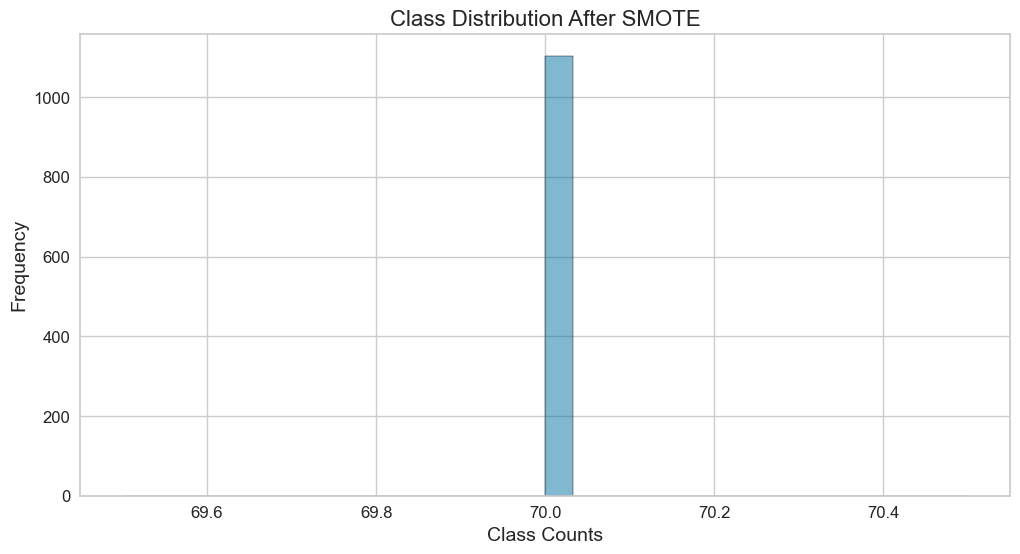

In [40]:
# Visualization
def plot_class_distribution(class_counts, title):
    count_values = list(class_counts.values())
    plt.figure(figsize=(12, 6))
    sns.histplot(count_values, kde=True, bins=30)
    plt.xlabel('Class Counts', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()




# Rebalanced class counts
plot_class_distribution(rebalanced_class_counts, "Class Distribution After SMOTE")

Clustering visual words

In [24]:
# Step 2: Combine all descriptors into a single array
all_descriptors = []
for descriptors in descriptors_by_class.values():
    all_descriptors.extend(descriptors)
all_descriptors = np.array(all_descriptors)

# Step 3: Perform KMeans clustering to create the visual vocabulary (codebook)
num_clusters = 200  # Number of visual words
vocab = KMeans(n_clusters=num_clusters, random_state=42).fit(all_descriptors)
joblib.dump(vocab, 'kmeans_codebook_final.pkl')

c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


['kmeans_codebook_final.pkl']

tSNE visualisation - not necessary to run - takes a long time

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


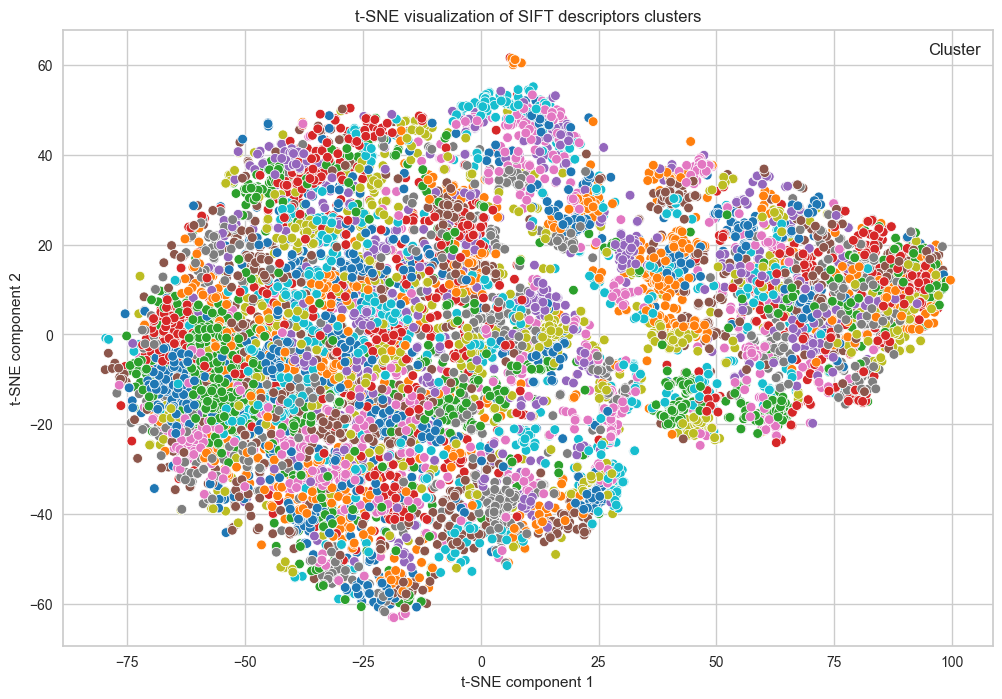

In [19]:

# Extract a manageable sample of SIFT descriptors for visualization
sampled_descriptors = descriptors_resampled[:10000]  # Adjust this number as needed for visualization

# Perform t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
reduced_descriptors = tsne.fit_transform(sampled_descriptors)

# Predict cluster labels for the sampled descriptors using k-means
sampled_labels = kmeans.predict(sampled_descriptors)

# Plot the t-SNE results
plt.figure(figsize=(12, 8))
sns.scatterplot(x=reduced_descriptors[:, 0], y=reduced_descriptors[:, 1], hue=sampled_labels, palette='tab10', legend=None)
plt.title('t-SNE visualization of SIFT descriptors clusters')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend(title='Cluster')
plt.show()


Compute histograms - visual words

In [26]:
import cv2
import numpy as np
import os
from sklearn.cluster import KMeans
import joblib

# Function to compute histograms for each image
def compute_histograms(image_paths, kmeans, num_clusters, nfeatures=0, nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6, batch_size=100):
    sift = cv2.SIFT_create(nfeatures=nfeatures, nOctaveLayers=nOctaveLayers, 
                           contrastThreshold=contrastThreshold, edgeThreshold=edgeThreshold, sigma=sigma)
    histograms = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        for image_path in batch_paths:
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                keypoints, descriptors = sift.detectAndCompute(img, None)
                if descriptors is not None:
                    words = kmeans.predict(descriptors)
                    hist, _ = np.histogram(words, bins=np.arange(num_clusters+1), density=True)
                else:
                    hist = np.zeros(num_clusters)
                histograms.append(hist)
    return np.array(histograms)

# Compute histograms for training and test images
X_train_hist_complete = compute_histograms(
    train_paths, vocab, num_clusters, nfeatures=700, nOctaveLayers=5, contrastThreshold=0.06
)
X_test_hist_complete = compute_histograms(
    test_paths, vocab, num_clusters, nfeatures=700, nOctaveLayers=5, contrastThreshold=0.06
)


Class weights

Best SVM model explored by hyperparameter search

In [29]:
# Compute class weights

class_weights = compute_class_weight('balanced', classes=np.unique(classes), y=classes)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(classes), class_weights)}

In [41]:


# Create and fit the classifier
clf4 = make_pipeline(StandardScaler(), SVC(C=100, gamma="auto", kernel='rbf', class_weight=class_weight_dict,probability=True, random_state=42))
clf4.fit(X_train_hist_complete, train_classes)

# Make predictions and evaluate
predictions = clf4.predict(X_test_hist_complete)
print("Classification Report for Complete Descriptors:")
print(classification_report(test_classes, predictions))
print("Confusion Matrix for Complete Descriptors:")
print(confusion_matrix(test_classes, predictions))

Classification Report for Complete Descriptors:


c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

       10F01       0.36      0.56      0.43         9
       10F02       0.40      0.50      0.44         8
       10F03       0.25      0.43      0.32         7
       10F04       1.00      0.40      0.57         5
       10F05       1.00      0.40      0.57         5
       10F06       0.00      0.00      0.00         4
       10F07       0.00      0.00      0.00         2
       10F08       0.00      0.00      0.00         2
       10F09       1.00      1.00      1.00         1
       10F10       1.00      1.00      1.00         3
       10F11       0.00      0.00      0.00         2
       10F12       1.00      1.00      1.00         3
       10F13       1.00      1.00      1.00         3
       10F14       1.00      0.67      0.80         3
       10M01       0.30      0.60      0.40        10
       10M02       0.15      0.45      0.22        11
       10M03       0.29      0.29      0.29         7
       10M04       0.33    

In [35]:
# Calculate accuracy
acc = accuracy_score(y_test_encoded, y_pred)
print(f'Accuracy: {acc}')

Accuracy: 0.676088185415489


Multi-layer perceptron - takes a long time - do not run

In [47]:

# Train and evaluate MLPClassifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,),learning_rate="adaptive", max_iter=500000, random_state=42)
mlp_clf.fit(X_train, y_train_encoded)
y_pred_mlp = mlp_clf.predict(X_test)
y_pred_mlp_decoded = label_encoder.inverse_transform(y_pred_mlp)
test_accuracy_mlp = accuracy_score(y_test, y_pred_mlp_decoded)
print(f'MLPClassifier Test accuracy: {test_accuracy_mlp}')


MLPClassifier Test accuracy: 0.5825325042396834


hyperparameter search for SVM - best classifier - do not run 

In [22]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encode the class labels as integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Initialize SVC and GridSearchCV
svm = SVC(class_weight=class_weights, random_state=42)
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Perform grid search
grid_search_svm.fit(X_train_scaled, y_train_encoded)

# Best parameters and score
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_
print(f'Best parameters for SVM: {best_params_svm}')
print(f'Best cross-validation accuracy for SVM: {best_score_svm}')

# Train the best SVM model
best_svm = grid_search_svm.best_estimator_
best_svm.fit(X_train_scaled, y_train_encoded)

# Evaluate the best SVM model
y_pred_best_svm = best_svm.predict(X_test_scaled)
y_pred_best_svm_decoded = label_encoder.inverse_transform(y_pred_best_svm)
test_accuracy_best_svm = accuracy_score(y_test, y_pred_best_svm_decoded)
print(f'Best SVM Test accuracy: {test_accuracy_best_svm}')

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters for SVM: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation accuracy for SVM: 0.641085108958989
Best SVM Test accuracy: 0.671848501978519


Archive - hyperparameter search for best SVM model

In [31]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encode the class labels as integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Apply SMOTE to balance the data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_encoded)

# Define parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'probability': [True]  # Ensure probability is True
}

# Initialize SVC and GridSearchCV
svm = SVC(class_weight='balanced', random_state=42)
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Perform grid search
grid_search_svm.fit(X_train_resampled, y_train_resampled)

# Best parameters and score
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_
print(f'Best parameters for SVM: {best_params_svm}')
print(f'Best cross-validation accuracy for SVM: {best_score_svm}')

# Train the best SVM model
best_svm = grid_search_svm.best_estimator_
best_svm.fit(X_train_resampled, y_train_resampled)

# Evaluate the best SVM model
y_pred_best_svm = best_svm.predict(X_test_scaled)
y_pred_best_svm_decoded = label_encoder.inverse_transform(y_pred_best_svm)
test_accuracy_best_svm = accuracy_score(y_test_encoded, y_pred_best_svm)
print(f'Best SVM Test accuracy: {test_accuracy_best_svm}')


Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [42]:
# Create a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_hist_complete,
    feature_names=['feature' + str(i) for i in range(X_train_hist_complete.shape[1])],
    class_names=['class' + str(i) for i in np.unique(test_classes )],
    discretize_continuous=True
)

# Choose a test instance
i = 0  # You can change this index to any instance you want to explain
exp = explainer.explain_instance(X_test_hist_complete[i], clf4.predict_proba, num_features=10)

# Display the explanation
exp.show_in_notebook(show_all=False)

In [44]:
# SHAP values for feature importance
explainer = shap.KernelExplainer(clf4.predict, X_train_hist_complete[:100])
shap_values = explainer.shap_values(X_test_hist_complete[:100])
shap.summary_plot(shap_values, X_test_hist_complete[:100], plot_type="bar")

# LIME for image sections
image_path = test_paths[0]
img = cv2.imread(image_path)
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img, clf4.predict_proba, top_labels=5, hide_color=0, num_samples=1000)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
plt.imshow(temp)
plt.show()

# Explainer Dashboard
explainer = ClassifierExplainer(clf4, X_test_hist_complete, test_classes)
dashboard = ExplainerDashboard(explainer)
dashboard.run()

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U7'), dtype('float64')) -> None